In [ ]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<a id="contents"></a>

## Table of Contents

- [**1. Introduction**](#introduction)

  - [**1.1 Differentiation Methods and Motivations**](#introduction1)
  - [**1.2 Automatic Differentiation**](#introduction2)

- [**2. Background**](#background)

  - [**2.1 Derivatives**](#background1)

  - [**2.2 Chain Rule**](#background2)

  - [**2.3 Elementary Functions**](#background3)

  - [**2.4 Forward Mode**](#background4)

  - [**2.5 Reverse Mode**](#background5)

  - [**2.6 Dual Number**](#background6)

- [**3. Usage**](#usage)

  - [**3.1 Installation**](#usage1)

  - [**3.2 How to use**](#usage2)

- [**4. Software Organization**](#softwareorganization)

  - [**4.1 Directory Structure**](#softwareorganization1)
  - [**4.2 Package & Distribution**](#softwareorganization2)
  - [**4.3 Modules to Include**](#softwareorganization3)
  - [**4.4 Test Design**](#softwareorganization4)

- [**5. Implementation**](#implementation)
  - [**5.1 Classes**](#Implementation1)
  - [**5.2 Core Data Structures**](#Implementation2)
  - [**5.3 Elementary Functions & Operator Overloading**](#Implementation3)
  - [**5.4 Handle Higher Dimensions**](#Implementation4)
  - [**5.5 Library Dependencies**](#Implementation5)

- [**6. Reference**](#reference)
- [**7. Licensing**](#licensing)


<a id="introduction"></a>

## 1. Introduction

[Return to contents](#contents)

`funAD` is a PyPi-distributed package that executes forward-mode and reverse-mode of automatic differentiation, enabling users to solve functional derivatives with high computational efficiency and machine precision.

<a id="introduction1"></a>

### 1.1 Differentiation Methods and Motivations

[Return to contents](#contents)


Differentiation is one of the most fundamental operations in science with a wide range of applications, including optimization, linearization, and root-finding problems. Several approaches to carry out the task have been proposed and gained great ubiquity:
 * Symbolic calculus methods accept an expression of a function and return the derivative of the given formula with respect to a specified variable. Despite offering analytical solutions at one's disposal, which has benefits in and of itself, symbolic mathematics programs usually have a high computation cost and may not always be applicable especially in cases of discontinuity, high complexity, and non-smoothness while finding the exact form of the derivative as a function. 
 * Numerical differentiation, such as the three-point forward difference formula, employs finite differences approximation to find rate of change of function value at a given point in the domain. Due to the nature of the approximation, it suffers from inaccuracy and instability.
 * In comparison, the automatic differentiation algorithm has the advantage of attaining both low computational costs and machine precision, overcoming the deficiencies of the two other methods introduced above. Its superior performance lies in its intricate design and implementation, which we will cover in the next section.

<a id="introduction2"></a>

### 1.2 Automatic Differentiation

[Return to contents](#contents)

As mentioned above, Automatic Differentiation is a competent tool for computing the Jacobian with reasonable computational costs and optimal accuracy, and thus making great contribution to progress made in fluid dynamics, aerospace, and so on. For instance, the back-propagation algorithm, a special case of reverse mode AD applied to scalar functions, is utilized to update node weights of neural network in machine learning. Here, `funAD` provides a robust, readily accessible implementation of the algorithm.

<a id="background"></a>

## 2. Background
AD calculates derivatives with the same accuracy as symbolic differentiation, but operates directly on the program of interest to obtain numerical values. The fundamental principle of AD is to decompose complex functions into elementary functions with known derivatives that form evaluation traces, and apply the Chain Rule to compose the derivatives of each step. Hence we first introduce Chain Rule and Elementary Function in order to understand AD.

[Return to contents](#contents)

<a id="background1"></a>

### 2.1 Derivatives

[Return to contents](#contents)

The derivative measures the sensitivity of the function value with respect to changes in its arguments. In one dimension, let $I \subseteq \mathbb{R}$ be an interval and let $x_0 \in I$. If exists, the derivative of the real-valued, single variable function $f \colon I → \mathbb{R}$ at $x_0$ is defined as,

$$f'(x_0) =\lim_{h→0} \frac{f(x_0+h)-f(x_0)}{h}$$

In multiple dimensions, for a vector-valued function with several arguments, such as the mapping $f \colon \mathbb{R}^{m} → \mathbb{R}^{n}$, the partial derivative of the $i$th vector component of function output with respect to the $j$th input can be written as,

$$\frac{\partial}{\partial{x_j}}f_i(\textbf{x}) = \lim_{h→0}\frac{f_i(x_1, x_2, ..., x_{j-1}, x_{j}+h, x_{j+1},...,x_{m})-f_i(x_1, x_2, ..., x_{j-1}, x_{j}, x_{j+1},...,x_{m})}{h}$$


In this case, the **Jacobian** matrix consisting of all the first-order partial derivatives of the function is often considered. The Jacobian $J(\textbf{x}^{(k)})$ of $f(\textbf{x})$ evaluated at $\textbf{x}^{(k)}$ will be a $n \times m$ matrix with elements 

$$J(\textbf{x}^{(k)})_{i,j} = \frac{\partial{f_i}}{\partial{x_j}}\Bigr\rvert_{\textbf{x} = {x}^{(k)}}$$

Moreover, given the same definition as above, it is oftentimes important to know the instantaneous rate of change of function value $f_i$ along a specified direction $p$ in the domain. Defined as the directional derivative of $f_i$ along the vector $p$, it is computed as the projection of the gradient vector $\nabla f_i$ along direction of $p$. 

$$D_pf_i=(\nabla f_i)ᵀp=\sum_{j=1}^{m} \frac{\partial{f_i}}{\partial{x_j}}$$


<a id="background2"></a>

### 2.2 Chain Rule



[Return to contents](#contents)

The central idea of Automatic Differentiation is the decomposition of complicated functional relations and the piecewise determination of derivatives based on the generalized Chain Rule.  

To recall, according to the Chain Rule, for scalar-valued function of one real variable $f(x)$ and $g(x)$,

$$\frac{\text{d}}{\text{d}x} (f(g(x))) = f'(g(x))g'(x)$$

When extended to real-valued functions of multiple variables in high dimensional coordinates $f\colon \mathbb{R}^n → \mathbb{R}$, the Chain Rule states that,

$$\nabla_{\textbf{x}} f = \sum_{i=1}^{n} \frac{\partial{f}}{\partial{y_i}} \nabla y_i(\textbf{x})$$

where $\textbf{x} = [x_1,x_2,...,x_m] \in \mathbb{R}^m$ vector of independent coordinates, $y(\textbf{x}) = [y_1(\textbf{x}), y_2(\textbf{x}), ...,y_n(\textbf{x})] \in \mathbb{R}^n$ n-dimensional input vector of $f$, and $\nabla y_i(\textbf{x}) = [\frac{\partial{y_i}}{\partial{x_1}}, \frac{\partial{y_i}}{\partial{x_2}}, ...,\frac{\partial{y_i}}{\partial{x_m}}]{ᵀ}$ 


In the most generalized form, the output of $f$ would be a vector instead of a scalar, in which case the derivative of each component $f_k$ can be found following the Chain Rule. 









<a id="background3"></a>

### 2.3 Elementary Functions

[Return to contents](#contents)

A complicated function formula is always made up of a ordered sequence of basic unitary and binary operations, known as the partial ordering of the operations associated with the function $f$. A function can therefore be broken down and structured into a handful of parallel and enclosing elementary functions, generating an intermediate result at each evaluation step when working from inside out.

Specifically, an elementary function is a function of a single variable that is defined as taking sums, products, roots and compositions of finitely many polynomial, rational, trigonometric, hyperbolic, and exponential functions, including possibly their inverse functions.$^1$Some common examples include,

* Constant functions: 2, $\pi$,$e$
* Rational powers of x: $x$,$x^3$,$\sqrt{x}$
* Exponential and logarithmic functions: $e^{x}$, $\ln{x}$, $10^{x}$, $\log_2{x}$
* Trigonometric functions: $\sin(x)$

When it comes to Automatic Differentiation, provided that the function has been formulated as a composition of elementary function structures, its derivative can be easily evaluated according to the Chain Rule by bringing forward and adding on to the derivatives of intermediate variables with consideration of the differentiation properties of involving elementary functions.

<a id="background4"></a>

### 2.4 Forward Mode

AD can be achieved through two modes: forward mode and reverse mode, which shares the same underlying practice, i.e., decomposing a complicated function into a series of elementary functions which led to intermediate variables denoted as $v_i$ for $i>0$, and, at each evaluation step, composing the derivatives together based on the Chain Rule. For the forward mode, we apply the Chain Rule in the direction consistent with the computational graph. The output is indeed the inner product of the gradient of the function and the seed vector$$\nabla f ⋅ p$$
where $\nabla f$ refers to the Jacobian and $p$ refers to the seed vector.

To be more detailed, while working on the calculations from inside out, at each step $i$, the algorithm keeps track two kinds of intermediate results: evaluation of $v_i$ and the directional derivative $D_pv_i$. The former is called the forward primal trace, and the latter forward tangent trace.

#### 2.4.1 The Use of Chain Rule
In the context of Automatic Differentiation, input function $f$ has independent coordinates $\textbf{x}$ and dependent coordinates $v_i$ for $i>0$, which are, in essence, the intermediate results. Since each intermediate result is built on top of previous ones, in the light of the Chain Rule, there is,

$$\nabla_x v_i = \sum_{j:\ \text{parent of i}} \frac{\partial v_i}{\partial v_j}\nabla_xv_j$$


#### 2.4.2 The Use of Seed Vector
In regard to AD, the convention is to "seed" the derivative with a preferably unit length vector. Let seed vector be denoted as $p$, then the directional derivative is  $$D_{p}v_{i} = (∇v_{i})^{T}⋅p$$
i.e. the derivative of $v_{i}$ in the direction of the seed vector p.

#### 2.4.2 Jacobian Finding

Recall from section 2.1, the Jacobian generalizes the gradient of function. In the case of AD, the columns of trace table are essentially the corresponding column of the Jacobian matrix. That is, with $p$ set to be the unit vector of coordinate $x_j$, then $[D_p f_1, D_p f_2, ..., D_p f_n]$ is the is exactly the jth column of Jacobian. To find the full Jacobian matrix, a total of $m$ passes is thus needed. 

#### 2.4.4 Example for Illustration

Here is an illustrative example of $$f(x) = x_{1}+x_{2}$$
Implementing the forward mode of AD, we form computational graph and evaluation trace in order to compute $f(x)$ and $f\prime(x)$.

Computational Graph

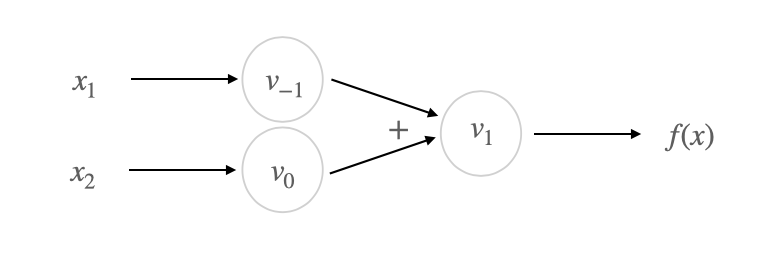

Gradient Computation using Forward Mode

| Forward Primal Trace | Forward Tangent Trace |Pass $p^{j=1}$=[1,0]| Pass $p^{j=2}$=[0,1] |
| :-----: | :-----: | :-----: | :-----: |
| $v_{-1}=x_{1}$ | $D_{p}v_{-1} = p_{1}$ | $D_{p}v_{-1} = 1$ | $D_{p}v_{-1} = 0$|
| $v_{0}=x_{2}$ | $D_{p}v_{0} = p_{2}$| $D_{p}v_{0} = 0$ | $D_{p}v_{0} = 1$|
| $v_{1}=v_{-1}+v_{0}$ | $D_{p}v_{1} = p_{1}+p_{2}$| $D_{p}v_{1} = 1$ | $D_{p}v_{1} = 1$|

[Return to contents](#contents)

<a id="background5"></a>

### 2.5 Reverse Mode

The reverse mode is ideal when the dimensionality of the input is significantly larger than the dimensionality of the output. Instead of propagating the derivative forward as the forward mode does, the reverse mode propagates the derivative backward from the output. The reverse mode consists of two parts: forward pass and reverse pass. 

#### 2.5.1 Forward Pass
During the forward pass, we evaluate the intermediate variables $v_{i}$ and store the partial derivatives of child nodes with respect to their parent node in memory$$\frac{\partial{v_{j}}}{\partial{v_{i}}}$$

#### 2.5.2 Reverse Pass
In reverse mode, we compute the partial derivatives of the output with respect to the intermediate variables known as adjoints reversely. The adjoint is denoted as $v_{i}$, where
$$\begin{align}\bar{v_{i}} &= \frac{\partial{f}}{\partial{v_{i}}}\\&=\sum_{\text{j: child of i}} \frac{\partial{f}}{\partial{v_{j}}}\frac{\partial{v_{j}}}{\partial{v_{i}}}\end{align}$$

For each specific node, we first apply chain rule to multiply the adjoint of child by the partial derivative of the child with respect to $v_{i}$ and take the sum of these products. In other words, $v_{i}$'s contribution to the output is defined by its children's contribution to the output as well as its affect on children. In this case, we obtain partial derivative of each input. 

#### 2.5.3 Example for Illustration

Recall the illstrative example from the forward mode in section 2.4 $$f(x) = x_{1}+x_{2}$$
This time, we compute $f(x)$ and $f\prime(x)$ using the computational graph and evaluation trace specified in the reverse mode of AD.

Computational Graph

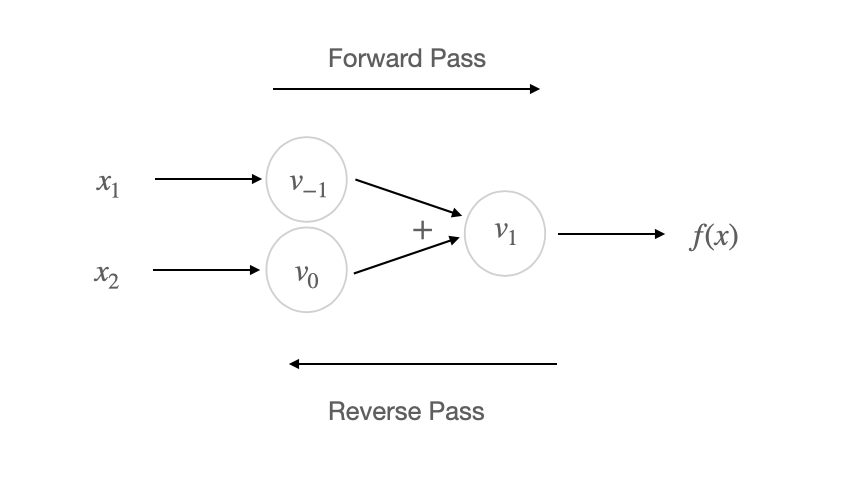

Gradient Computation using Reverse Mode

* Forward pass: Intermediate and Partial Derivatives

* Reverse Pass: Adjoint

| Intermediate | Partial Derivatives | Adjoint |
| :-----: | :-----: | :-----: |
| $v_{-1}=x_{1}$ | | $\bar{v_{-1}}=\frac{\partial{f}}{\partial{v_{1}}}\frac{\partial{v_{1}}}{\partial{v_{-1}}}=\bar{v_{1}}\frac{\partial{v_{1}}}{\partial{v_{1}}}=1$ |
| $v_{0}=x_{2}$ |  | $\bar{v_{0}}=\frac{\partial{f}}{\partial{v_{1}}}\frac{\partial{v_{1}}}{\partial{v_{0}}}=\bar{v_{1}}\frac{\partial{v_{1}}}{\partial{v_{0}}}=1$|
| $v_{1}=v_{-1}+v_{0}$ |$\frac{∂v_{1}}{∂v_{-1}}=1$;$\frac{∂v_{1}}{∂v_{0}}=1$|$\bar{v_{1}}=\frac{\partial{v_{1}}}{\partial{v_{1}}}=1$|




#### 2.5.4 Comparison to Forward Mode
In contrast to the forward mode, the reverse mode of AD does not involve directional derivatives. Instead, it calculates and stores the partial derivatives. The reverse mode can only run after the forward pass is completed and it is memory-intensive

[Return to contents](#contents)

<a id="background6"></a>

### 2.6 Dual Number

A dual number consists of a real part and a dual part, with the following format $$z=a+bϵ$$ where a represents the real part $f$, b represents the dual part $f\prime$, and $\epsilon$ is a nonzero and nonreal number which satisfies $\epsilon^2=0$.

Noticing the format of dual numbers is very similar to complex numbers. The key difference here is that for dual numbers $\epsilon^2=0$ whereas for complex number $i^2=-1$.

Dual numbers are extremely useful when calculating function values and function derivatives in AD setups. For instance, say we have $$f(x) = x^2$$ and would like to calculate $f(x)$ and $f\prime(x)$. We first convert x into a dual number as $x=a+bϵ$. Then $$\begin{align}f(x) &= (a+bϵ)^2 \\&= a^2 + 2abϵ + b^2ϵ^2\\&= a^2 + 2abϵ\end{align}$$ where $f(x) = a^2$ and $2abϵ$ contains the derivative of function $f\prime(x)$ evaluated at a. 

[Return to contents](#contents)

<a id="usage"></a>

## 3. Usage

[Return to contents](#contents)

`funAD` is available through the Python Package Index (PyPI). Refer to the PyPI webpage for more project description.

<a id="usage1"></a>

### 3.1 Installation

[Return to contents](#contents)

To install `funAD` with pip, run the following command:

    pip install funAD

<a id="usage2"></a>

### 3.2 How to use

[Return to contents](#contents)

After successful installation, the user can import `funAD` and its dependencies.

    import funAD as ad
    from funAD import Forward, Dual

For example, a user would like to compute the derivative of function $$f=x_1+e^{x_2}$$ w.r.t. $x_1$,$x_2$, with input values $x_1=1$ and $x_2=2$ ($x_1, x_2$ are real numbers).

    x1 = Dual(val=1,pos=0)
    x2 = Dual(val=2,pos=1)

In the code above, *val* specifies the real value of independent variables, *pos* specifies the index of each variable if there are multiple independent variables. By default, *der* argument takes 1 in the instantiation of a Dual object.

Now we can calculate the value of function and derivative based on operators implemented in the Dual class.

    f = Forward(x1+ad.exp(x2))
    f.func_value() # return the value of function
    f.diff() # return the derivative of function as a Numpy array
    f.diff()[1] # return the derivative of function w.r.t. x2 


<a id="softwareorganization"></a>

## 4. Software Organization

[Return to contents](#contents)

<a id="softwareorganization1"></a>

### 4.1 Directory Structure

```
team21/
│   
├── LICENSE
├── pyproject.toml
├── README.md
├── setup.cfg
└─── docs/
│   └── milestone1.md
│   │   ...
└─── src/
│   └── funAD
│       ├── __init__.py
│       ├── automatic_differentiation_classes.py
│       ├── elementary_functions.py
│       ├── dual_number_class.py
│       │   ...
└── tests/
│   ├── dual_number_class_tests.py
│   ├── elementary_functions_tests.py
│   ├── forward_mode_tests.py
│   │   ...

```

<a id="softwareorganization2"></a>

### 4.2 Package & Distribution

We build and package our software using the the standard packaging tool [setuptools](https://packaging.python.org/key_projects/#setuptools)

We will specify minimum build requirements in a `pyproject.toml` file that is consistent with PEP518. We will use a `setup.cfg` file to define our packages' metadata.

Our package would be distributed through [Python Package Index (PyPi)](https://pypi.org/)


<a id="softwareorganization3"></a>

### 4.3 Modules to Include

 `Numpy`: provide multi-dimensional array and matrix computation support, we will also rely on `Numpy`'s mathematic operations and elementary function implementations (such as sin(), arctan(), etc.)

<a id="softwareorganization4"></a>

### 4.4 Test Design

The functionality tests will be included in the `tests` directory in the root directory. We plan to use `Travis-CI` to test coverage and integration.

<a id="implementation"></a>

## 5. Implementation

[Return to contents](#contents)

<a id="implementation1"></a>

### 5.1 Classes

*   Dual - a class modeling dual numbers. **We plan to implement this class first, as the Dual object is the core data structure in our implementation(see reasons in the next section).** 
    * `__init__(self,val,der=1,pos=0)`: Instantiate a Dual object by specifying real part and dual part. `pos` specifies the index of each variable if there are multiple independent variables.
    * `__add__(self,other)`: the addition between two Dual objects, return a new Dual object.
    * `__radd__(self,other)`: handle addition with regular numbers. Note that `self` is a Dual object, while `other` is a real number (floating point number or integer).
    * `__sub__(self,other)`: substract Dual object `self` by Dual object `other`, return a new Dual object
    * `__rsub__(self,other)`: handle substraction with regular numbers. Note that `self` is a Dual object, while `other` is a real number (floating point number or integer).
    * `__mul__(self,other)`: the multiplication between two Dual objects, return a new Dual object.
    * `__rmul__(self,other)`: handle multiplication with regular numbers. Note that `self` is a Dual object, while `other` is a real number (floating point number or integer).
    * `__truediv__(self,other)`: divide Dual object `self` by Dual object `other`, return a new Dual object.
    * `__rtruediv__(self,other)`: handle division with regular numbers. Note that `self` is a Dual object, while `other` is a real number (floating point number or integer).
    * `__pow__(self,other)`: power operation of two Dual objects, return a new Dual object
    * `__rpow__(self,other)`: handle power operation with regular numbers. Note that `self` is a Dual object, while `other` is a real number (floating point number or integer).

*   AD - the base class for automatic differentiation.
    *   `__init__(self,f)`: Instantiate an AD object with a function expression. `f` should be a Dual object. To represent vector functions, `f` should be an array of Dual objects. 
    *   `func_value(self)`: calculate and return the function value
*   Forward - child class of AD, running forward mode AD
    *   `__init__(self,f)`: Instantiate an Forward object with a function expression. `f` should be a Dual object. To represent vector functions, `f` should be an array of Dual objects. 
    *   `diff(self)`: Calculate the gradient/Jacobian. The function calls `diff(self,pos=0)`, packs each return value in a `NumPy` array, and returns the array.
    *   `direc_diff(self,p)`: Calculate and derivative on the direction of seed vector `p`. `p` is of type `NumPy` array. The function calls `diff(self,pos=0)`. The return value is a `NumPy` array.
    *   `diff(self,pos=0)`: Calculate the derivative of function w.r.t. a specified coordinate `x` where `x.pos=pos`. A scalar value is returned.

Demo code:

In [ ]:
# demo code, please do not run
import numpy as np
import funAD as ad
from funAD import Dual, Forward

# initialize Dual objects with input values
# the derivatives (dual parts) are initialized to be default value of 1's
x1 = Dual(2)
x2 = Dual(3)

# addition between Dual objects
(x1+x2).val
>>> 5
(x1+x2).der
>>> 2.0

# addition between a Dual object and a regular number
(x1+1).val
>>> 3
(x1+1).der
>>> 1.0

# initialize dual number object with input values and positional attributes
# the positional attribute is used for multiple independent variable inputs
# so we can identify which differentiated corresponds to which variable
x1 = Dual(2,pos=0)
x2 = Dual(3,pos=1)

# initialize AD object based on user defined function
f = Forward(x1*x2 + ad.exp(x2))

# calculate the gradient of the function
f.diff()
# since x1 has pos = 0 and x2 has pos = 1,
# 3.0 and 22.08553692 correspond to df/dx_1 and df/dx_2, respectively
>>> array([ 3.0, 22.08553692])

# calculate the directional derivative
p = np.array([1,0])
# this shows the directional derivative when p = [1,0]^T 
f.direc_diff(p)
>>> 3.0

<a id="implementation2"></a>

### 5.2 Core Data Structures
[Return to contents](#contents)

##### **Dual**

we plan to implement Dual as the core data structure. Dual objects mimic dual numbers, which take current function value as the real part and the derivative as the dual part. Thus, it encapsulates the two components in a single structure and transitions forward into the next node in the computational graph. The transition from one node to its child is achieved by basic operations(+-*/...) between two Dual objects.  

##### **`NumPy` array**

We plan to use `NumPy` array as the main data structure to store values. For instance, the derivative/ Jacobian computed by `diff()` method will be returned as a `NumPy` array/matrix depending the dimensions.

##### **Dictionary**

To resemble the computational graph, we plan to use Python dictionaries to explicitly store the values of each node. The dictionaries will have the following structure

     dict = {node1:{parents:[p1,p2,...],
                    children:[c1,c2,...],
                    value:val1},
             node2:{...}}

where each node is a Dual object.

<a id="implementation3"></a>

### 5.3 Elementary Functions & Operator Overloading
[Return to contents](#contents)

Upon our current design, arithmetic operations (e.g. +-\*/) and functions (e.g. sin,sqrt,log) will be evaluated on Dual objects. We make this possible by overloading arithmetic operations (e.g. +-\*/) in `Dual` class and overloading elementary functions in `elementary_functions.py` module. Note that after the user import `funAD`, the overwritten functions in `elementary_functions.py` will be callable in the namespace of `funAD`. As the result, the user can do operations on Dual objects just like on regular numbers as well as operations across Dual objects and regular numbers. Below we show three examples about our overloading template.



```

# In dual_number_class.py, we overwrite addition within new Dual object with updated attributes

from numpy import np
class Dual:
...
      def __add__(self,other):
          # handle addition between Dual objects
          try:
            res_val = self.val + other.val
            res_der = self.der + other.der
          # handle addition with a regular number
          except AttributeError as ae:
            res_val = self.val + other
            res_der = self.der
          return Dual(res_val,res_der)
...

# In elementary_functions.py, we overload elementary functions such as sine and exponential functions
...

import numpy as np
def sin(x):
    # handle Dual object
    try:
      res_val = np.sin(x.val)
      res_der = np.cos(x.val)*x.der
      return Dual(res_val,res_der)
    # handle regular number
    except AttributeError as ae:
      return np.sin(x)
    

def exp(x):
    # handle Dual object
    try:
      res_val = np.exp(x.val)
      res_der = np.exp(x.val)*x.der
      return Dual(res_val,res_der)
    # handle regular number
    except AttributeError as ae:
      return np.exp(x)    
...
```




Demo code:

In [ ]:
# demo code, please do not run
import numpy as np
import funAD as ad
from funAD import Dual

x1 = Dual(np.pi/2, 1.0)
x2 = Dual(-1*np.pi/2, 1.0)

# addition between Dual objects
(x1+x2).val
>>> 0.0 
(x1+x2).der
>>> 2.0

# addition between a Dual object and a regular number
(x1+1).val
>>> 2.5707963267948966
(x1+1).der
>>> 1.0

# sine function on a Dual object
ad.sin(x1).val
>>> 1.0
ad.sin(x1).der
>>> 6.123233995736766e-17

# exponential function on a Dual object
ad.exp(x1).val
>>> 4.810477380965351
ad.exp(x1).der
>>> 4.810477380965351

Furthermore, we will implement functions listed below in `elementary_functions.py` to work on both regular numbers and Dual objects.

| Elementary Function Name   | Overload Function Name |
| :--------------------:     | :---------------------:|
| sine                       | $\sin(x)$              | 
| cosine                     | $\cos(x)$              |
| tangent                    | $\tan(x)$              |
| arcsine                    | $\arcsin(x)$           |
| arcosine                   | $\arccos(x)$           |
| arctangent                 | $\arctan(x)$           |
| exponential                | $\exp(x)$              |
| logarithm                  | $\log(x, base)$        |
| power                      | $pow(x, n)$            |
| square root                | $sqrt(x)$              |


<a id="implementation4"></a>

### 5.4 Handle Higher Dimensions
[Return to contents](#contents)

Our implementation considers general functions 
$$ f: \mathbb{R}^{m} → \mathbb{R}^{n} \;\;\forall m,n$$
where m is the dimension of independent variables and n is the dimension of function outputs. We make this possible by modeling the function object as an array of Dual objects.

**$f: \mathbb{R} → \mathbb{R}$**

In this case, `f` is a scalar function of single input. `f` is simply a Dual object that builds on another Dual object `x`. 

**$f: \mathbb{R}^{m} → \mathbb{R}$**

In this case, f is a scalar function of vector input. `f` is a Dual object that builds on multiple Dual objects `x1,x2,...,xm`.

**$f: \mathbb{R}^{m} → \mathbb{R}^{n}$**

In this case, f is a vector function of vector input. `f` is an array of Dual objects with length n, and each component of the array builds on multiple Dual objects `x1,x2,...,xm`.

To calculate the gradient/Jacobian, we implement `diff()` based on a similar structure. `diff()` calls `diff(pos=0)` to calculate the derivative w.r.t. each independent variable `x` and then packs the derivatives inside a NumPy array. This structure illustrates "m passes" in the forward mode. Note that for vector functions, the method will iterate the above steps for each function component and packs the values inside a Numpy matrix. 

As the result, a gradient `g` will be an array with length m, where each component of the array is returned by `diff(f,pos)`. Similarly, a Jacobian `J` will be an 2-d array with size n*m, where each entry is given by `diff(f[i],pos)`, with i denotes the index of the evaluated function component.

<a id="implementation5"></a>

### 5.5 Library Dependencies
[Return to contents](#contents)

Our implementation will depend on `NumPy` library. We employ `NumPy`'s* array and matrix functionality to handle vectors and matrices and expand/overload its  arithmetic operations and computation functions (e.g., `np.exp()`) to build our elementary functions. All dependencies would be installed through setup.cfg file under the root directory. 

<a id="reference"></a>

## 6. Reference

[Return to contents](#contents)

1. Wikimedia Foundation. (2022, September 16). Directional derivative. Wikipedia. Retrieved October 19, 2022, from https://en.wikipedia.org/wiki/Directional_derivative 

<a id="licensing"></a>

## 7. Licensing

[Return to contents](#contents)

We will use the GNU General Public License. This copyleft license not only gives users freedom to use and modify our code but also forbid others from imposing further restrictions downstream. We believe in GNU's official statement that "anyone who redistributes the software, with or without changes, must pass along the freedom to further copy and change it." We hope this would promote the open-source spirit of development communities.

More on this particular license can be found here: https://www.gnu.org/licenses/gpl-3.0.html 
